In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from datetime import datetime
pd.set_option('display.max_colwidth', None)
sns.set()

GK_GREEN = '#21B534'
GK_GREEN_LIGHT = '#07f596'
GK_PURPLE = '#7494EA'
GK_BLUE = '#19535F'
RED = "#f55b5b"
DARK_RED = "#db0000"
GREY = "#a6a6a6"
BLUE = "#4287f5"
LIGHT_GREEN = '#88D39B'

COLOUR_PALETTE = sns.color_palette('Greens_r')
GK_GREEN = COLOUR_PALETTE[1]
TWO_COLOUR_PALETTE = [GK_GREEN, GK_PURPLE]
THREE_COLOUR_PALETTE = [GK_GREEN, GK_PURPLE, GK_BLUE]
FOUR_COLOUR_PALETTE = THREE_COLOUR_PALETTE + [LIGHT_GREEN]

MAJOR_RELEASE_TYPE = 'major'
MINOR_RELEASE_TYPE = 'minor'
PATCH_RELEASE_TYPE = 'patch'
NA_RELEASE_TYPE = pd.NA

PROJECT_ROOT = '..'
PLOTS_PATH = f'{PROJECT_ROOT}/plots'

BINS_COUNT = 40

## Load Data

In [2]:
issues = pd.read_csv(f'{PROJECT_ROOT}/csv/aug_greenkeeper_issues.csv')
comments = pd.read_csv(f'{PROJECT_ROOT}/csv/greenkeeper_comments.csv')
events = pd.read_csv(f'{PROJECT_ROOT}/csv/greenkeeper_events.csv')
commits = pd.read_csv(f'{PROJECT_ROOT}/csv/aug_greenkeeper_commits.csv')
package_names = pd.read_csv(f'{PROJECT_ROOT}/csv/greenkeeper_package_names.csv')
library_versions = pd.read_csv(f'{PROJECT_ROOT}/csv/aug_breaking_library_versions.csv')
library_releases = pd.read_csv(f'{PROJECT_ROOT}/csv/breaking_library_releases.csv')

/Users/BenRombaut/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,16,17,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
unique_package_count = len(issues['issue_repo_url'].unique())
print(f"{len(issues)} Greenkeeper Breaking Build issue reports (across {unique_package_count} unique projects)")
print(f"{len(comments)} comments for those issue reports")
print(f"{len(events)} events on those issue reports")
# print(f"\tIncludes {events['event_description'].unique()}")
print(f"{len(commits)} commits that were referenced in these breaking issue reports")
print(f"Total of {len(library_versions)} version release records for libraries that have at least 1 breaking release")
print(f"Release frequency information on {len(library_releases)} libraries")

123197 Greenkeeper Breaking Build issue reports (across 12134 unique projects)
365625 comments for those issue reports
209750 events on those issue reports
17623 commits that were referenced in these breaking issue reports
Total of 556742 version release records for libraries that have at least 1 breaking release
Release frequency information on 7361 libraries


#### Custome Helper Functions

In [4]:
def get_issue(id):
    return issues[issues['issue_id'] == id]

def get_issue_url(id):
    return issues[issues['issue_id'] == id]['issue_url']

def get_comment(id):
    return comments[comments['comment_id'] == id]

def get_comments_for_issue(id):
    return comments[comments['comment_issue_id'] == id]

def get_event(id):
    return events[events['event_id'] == id]

def calculate_percent(numer, denom):
    return round((numer/denom)*100, 2)

def get_update_type(prev_ver, new_ver):
    if pd.isnull(prev_ver) or pd.isnull(new_ver):
        return NA_RELEASE_TYPE
    try:
        prev_split = prev_ver.split('.')
        new_split = new_ver.split('.')
        if int(new_split[0]) > int(prev_split[0]):
            return MAJOR_RELEASE_TYPE
        elif int(new_split[1]) > int(prev_split[1]):
            return MINOR_RELEASE_TYPE
        else:
            return PATCH_RELEASE_TYPE
    except Exception as e:
        return NA_RELEASE_TYPE
    
def get_issue_id_for_commit(commit):
    try:
        event_id = commit.commit_event_id
        event = get_event(event_id)
        if event.size == 0:
            return np.nan
        issue = get_issue(event.event_issue_id.values[0].astype(np.int64))
        if issue.size == 0:
            return np.nan
        return issue.issue_id.values[0].astype(np.int64)
    except Exception:
        return np.nan
    
def strfdelta(tdelta, fmt):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

def save_plot(plot, file_name, dpi=400):
    plot.savefig(f'{PLOTS_PATH}/{file_name}', dpi=400)
    
def create_hist_plot(params, ax, cbar_ax=None, color=GK_GREEN, bins=80):
    result = sns.histplot(
        **params,
        ax=ax,
        kde=True,
        bins=bins,
        color=color,
        cbar=cbar_ax is not None,
        cbar_ax=cbar_ax
    )
    return result

def create_reg_line(params, ax):
    result = sns.regplot(
        **params,
        scatter=False,
        line_kws={"color": GK_PURPLE},
        ax=ax,
    )
    return result

### Augment Data

In [5]:
events['event_description'] = events['event_description'].astype('category')
issues["issue_created_at"] = issues["issue_created_at"].astype("datetime64")
issues["issue_updated_at"] = issues["issue_updated_at"].astype("datetime64")
issues["issue_closed_at"] = issues["issue_closed_at"].astype("datetime64")
issues['update_type'] = issues['update_type'].astype('category')
library_releases["first_release_date"] = library_releases["first_release_date"].astype("datetime64")
library_releases["last_release_date"] = library_releases["last_release_date"].astype("datetime64")

library_releases["avg_time_between_releases"] = \
    pd.to_timedelta(library_releases["avg_time_between_releases"])

comments['comment_created_at'] = pd.to_datetime(comments['comment_created_at'])
comments['comment_updated_at'] = pd.to_datetime(comments['comment_updated_at'])
comments['comment_user_type'] = comments['comment_user_type'].astype('category')

### How many dependencies do packages have?

In [6]:
import json

deps_dtos = list()
for index, row in package_names.iterrows():
    deps_str = row['package_dependencies']
    if pd.isna(deps_str):
        deps = dict()
    else:
        deps = json.loads(deps_str.replace("'", '"')) if ~pd.isna(deps_str) else dict()

    dev_deps_str = row['package_dev_dependencies']
    if pd.isna(dev_deps_str):
        dev_deps = dict()
    else:
        dev_deps = json.loads(dev_deps_str.replace("'", '"')) if dev_deps_str else dict()
    deps_dtos.append({
        'package_name': row['package_name'],
        'deps': deps,
        'dev_deps': dev_deps,
    })
    
DEP = 'Dependency'
DEV_DEP = 'Dev Dependency'
packages = list()
deps_names = list()
deps_versions = list()
deps_types =  list()

for deps_dto in deps_dtos:
    package = deps_dto['package_name']
    for dep_name, dep_version in deps_dto['deps'].items():
        packages.append(package)
        deps_names.append(dep_name)
        deps_versions.append(dep_version)
        deps_types.append(DEP)
    for dep_name, dep_version in deps_dto['dev_deps'].items():
        packages.append(package)
        deps_names.append(dep_name)
        deps_versions.append(dep_version)
        deps_types.append(DEV_DEP)
        
dependencies_df = pd.DataFrame({
    'package': packages,
    'deps_name': deps_names,
    'deps_version': deps_versions,
    'deps_type': deps_types,
})


# grouped_deps = \
#     dependencies_df.groupby(by=['package', 'deps_type'])['deps_name']\
#     .count()\
#     .reset_index(name='count')


In [7]:
deps_groups = dependencies_df.groupby(by=['deps_name'])
provider_packages_list = list()
clients_list = list()
for name, group in deps_groups:
    provider_packages_list.extend([name for i in range(len(group))])
    clients_list.extend(list(group.apply(lambda row: row['package'], axis=1)))

provider_to_clients = pd.DataFrame({
    'provider': provider_packages_list,
    'client': clients_list,
})

In [8]:
issues_dist = issues[['issue_id', 'issue_repo_url', 'issue_dependency_name', 'issue_dependency_actual_version', 'issue_dependency_next_version']].copy()
issues_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123197 entries, 0 to 123196
Data columns (total 5 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   issue_id                         123197 non-null  int64 
 1   issue_repo_url                   123197 non-null  object
 2   issue_dependency_name            117384 non-null  object
 3   issue_dependency_actual_version  117402 non-null  object
 4   issue_dependency_next_version    79193 non-null   object
dtypes: int64(1), object(4)
memory usage: 4.7+ MB


In [9]:
ptcp = provider_to_clients.groupby(by=['provider']).size().to_frame('clients').reset_index()
ptcp['breaking_issues'] = ptcp.apply(lambda row: len(issues_dist[issues_dist['issue_dependency_name'] == row['provider']].index), axis=1)

In [10]:
ptcp[ptcp['breaking_issues'] > 0]

,provider,clients,breaking_issues
3,3box,2,2
6,3box-orbitdb-plugins,2,3
11,42-cent-base,12,5
22,@0x/utils,1,1
23,@0x/web3-wrapper,1,1
...,...,...,...
25830,zombie,7,3
25831,zone.js,312,61
25833,zora,4,3
25834,zotero-plugin,1,1


## Most breaking packages by proprtion

In [11]:
library_versions["version_published_at"] = library_versions["version_published_at"].astype("datetime64")
library_versions = library_versions.dropna(subset=['package_name'])
library_versions = library_versions.sort_values(['package_name', 'version_published_at'])

library_versions.groupby(by=['package_name'])
grouped_package_releases = library_versions.groupby(by='package_name')
packages = list()
prev_releases = list()
curr_releases = list()
time_between_releases = list()
for package_name, group in grouped_package_releases:
    prev_release = None
    prev_release_date = None
    curr_release = None
    curr_release_date = None
    for row_index, row in group.iterrows():
        prev_release = curr_release
        prev_release_date = curr_release_date
        curr_release = row['version']
        curr_release_date = row['version_published_at']
        if prev_release_date is None:
            continue
        release_time_diff = (curr_release_date - prev_release_date)
        packages.append(package_name)
        prev_releases.append(prev_release)
        curr_releases.append(curr_release)
        time_between_releases.append(release_time_diff)
        
        
my_df = pd.DataFrame({
    'package': packages,
    'prev_release': prev_releases,
    'curr_release': curr_releases,
    'time_between_release': time_between_releases,
})

In [12]:
def get_client_count(row):
    try:
        return ptcp.loc[row['package']]['clients']
    except:
        return pd.NA
my_df['client_count'] = my_df.apply(get_client_count, axis=1)
my_df = my_df.dropna(subset=['client_count'])

In [47]:
my_df.head(10)
len(my_df)

499389

In [14]:
issues_dist = issues[['issue_id', 'issue_repo_url', 'issue_dependency_name', 'issue_dependency_actual_version', 'issue_dependency_next_version']].copy()
issues_dist = issues_dist.dropna(subset=['issue_dependency_name', 'issue_dependency_actual_version', 'issue_dependency_next_version'])
issues_dist

,issue_id,issue_repo_url,issue_dependency_name,issue_dependency_actual_version,issue_dependency_next_version
5631,576010086,https://api.github.com/repos/ealush/butter-toast,@babel/cli,7.8.3,7.8.4
5632,576010086,https://api.github.com/repos/ealush/butter-toast,@babel/core,7.8.6,7.8.7
5633,576010086,https://api.github.com/repos/ealush/butter-toast,@babel/plugin-proposal-class-properties,7.8.0,7.8.3
5634,576010086,https://api.github.com/repos/ealush/butter-toast,@babel/plugin-transform-runtime,7.8.0,7.8.3
5635,576010086,https://api.github.com/repos/ealush/butter-toast,@babel/preset-env,7.8.6,7.8.7
...,...,...,...,...,...
85124,359772997,https://api.github.com/repos/andcards/react-gesture,binary-ui-styles,0.6.50,0.6.51
85125,359571661,https://api.github.com/repos/andcards/react-gesture,binary-ui-styles,0.6.49,0.6.50
85126,359504712,https://api.github.com/repos/andcards/react-gesture,binary-ui-styles,0.6.48,0.6.49
85127,359487306,https://api.github.com/repos/andcards/react-gesture,binary-ui-styles,0.6.47,0.6.48


In [115]:
# THIS WILL TAKE HOURS!!
def get_number_of_breaks(row):
    try:
        breaking_issues = issues_dist.loc[
            (issues_dist['issue_dependency_name'] == row['package']) &
            (issues_dist['issue_dependency_actual_version'] == row['prev_release']) &
            (issues_dist['issue_dependency_next_version'] == row['curr_release'])
        ]
        return len(breaking_issues)
    except Exception as e:
        return pd.NA
    
my_df['breaking_issues'] = my_df.apply(get_number_of_breaks, axis=1)
# my_df.head(10)

<ipython-input-115-e06c9cebd174>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df['breaking_issues'] = my_df.apply(get_number_of_breaks, axis=1)


In [79]:
# my_df.to_csv(f'{PROJECT_ROOT}/csv/releases_breaking_issues.csv', index=False)
my_df = pd.read_csv(f'{PROJECT_ROOT}/csv/releases_breaking_issues.csv')
my_df['time_between_release'] = pd.to_timedelta(my_df['time_between_release'])
my_df['time_until_next_release'] = pd.to_timedelta(my_df['time_until_next_release'])
my_df['ratio'] = my_df['breaking_issues'] / my_df['client_count']

In [70]:
my_df.head()

,package,prev_release,curr_release,time_between_release,client_count,breaking_issues,ratio,time_until_next_release
0,3box,0.0.1,0.0.2,15 days 21:44:20.609000,2,0,0.0,1 days 16:38:51.812000
1,3box,0.0.2,0.0.3,1 days 16:38:51.812000,2,0,0.0,0 days 00:59:30.090000
2,3box,0.0.3,0.0.4,0 days 00:59:30.090000,2,0,0.0,4 days 07:42:30.188000
3,3box,0.0.4,0.0.5-beta-1,4 days 07:42:30.188000,2,0,0.0,0 days 00:00:51.060000
4,3box,0.0.5-beta-1,0.0.5-beta-2,0 days 00:00:51.060000,2,0,0.0,1 days 07:40:06.798000


In [67]:
# THIS WILL TAKE HOURS
idx = 0
my_df['time_until_next_release'] = pd.NA
curr_percent = 0
new_percent = 0
total = len(my_df)
# temp = my_df.head()
while idx < len(my_df) - 1:
    new_percent = round((idx / total) * 100, 1)
    if new_percent != curr_percent:
        curr_percent = new_percent
        print(f'{curr_percent}% Done')
    curr_row = my_df.iloc[idx]
    next_row = my_df.iloc[idx + 1]
    if next_row['package'] == curr_row['package']:
        my_df.iloc[idx, 7] = next_row['time_between_release']
    idx += 1
my_df

0.1% Done
0.2% Done
0.3% Done
0.4% Done
0.5% Done
0.6% Done
0.7% Done
0.8% Done
0.9% Done
1.0% Done
1.1% Done
1.2% Done
1.3% Done
1.4% Done
1.5% Done
1.6% Done
1.7% Done
1.8% Done
1.9% Done
2.0% Done
2.1% Done
2.2% Done
2.3% Done
2.4% Done
2.5% Done
2.6% Done
2.7% Done
2.8% Done
2.9% Done
3.0% Done
3.1% Done
3.2% Done
3.3% Done
3.4% Done
3.5% Done
3.6% Done
3.7% Done
3.8% Done
3.9% Done
4.0% Done
4.1% Done
4.2% Done
4.3% Done
4.4% Done
4.5% Done
4.6% Done
4.7% Done
4.8% Done
4.9% Done
5.0% Done
5.1% Done
5.2% Done
5.3% Done
5.4% Done
5.5% Done
5.6% Done
5.7% Done
5.8% Done
5.9% Done
6.0% Done
6.1% Done
6.2% Done
6.3% Done
6.4% Done
6.5% Done
6.6% Done
6.7% Done
6.8% Done
6.9% Done
7.0% Done
7.1% Done
7.2% Done
7.3% Done
7.4% Done
7.5% Done
7.6% Done
7.7% Done
7.8% Done
7.9% Done
8.0% Done
8.1% Done
8.2% Done
8.3% Done
8.4% Done
8.5% Done
8.6% Done
8.7% Done
8.8% Done
8.9% Done
9.0% Done
9.1% Done
9.2% Done
9.3% Done
9.4% Done
9.5% Done
9.6% Done
9.7% Done
9.8% Done
9.9% Done
10.0% Done

75.5% Done
75.6% Done
75.7% Done
75.8% Done
75.9% Done
76.0% Done
76.1% Done
76.2% Done
76.3% Done
76.4% Done
76.5% Done
76.6% Done
76.7% Done
76.8% Done
76.9% Done
77.0% Done
77.1% Done
77.2% Done
77.3% Done
77.4% Done
77.5% Done
77.6% Done
77.7% Done
77.8% Done
77.9% Done
78.0% Done
78.1% Done
78.2% Done
78.3% Done
78.4% Done
78.5% Done
78.6% Done
78.7% Done
78.8% Done
78.9% Done
79.0% Done
79.1% Done
79.2% Done
79.3% Done
79.4% Done
79.5% Done
79.6% Done
79.7% Done
79.8% Done
79.9% Done
80.0% Done
80.1% Done
80.2% Done
80.3% Done
80.4% Done
80.5% Done
80.6% Done
80.7% Done
80.8% Done
80.9% Done
81.0% Done
81.1% Done
81.2% Done
81.3% Done
81.4% Done
81.5% Done
81.6% Done
81.7% Done
81.8% Done
81.9% Done
82.0% Done
82.1% Done
82.2% Done
82.3% Done
82.4% Done
82.5% Done
82.6% Done
82.7% Done
82.8% Done
82.9% Done
83.0% Done
83.1% Done
83.2% Done
83.3% Done
83.4% Done
83.5% Done
83.6% Done
83.7% Done
83.8% Done
83.9% Done
84.0% Done
84.1% Done
84.2% Done
84.3% Done
84.4% Done
84.5% Done

,package,prev_release,curr_release,time_between_release,client_count,breaking_issues,ratio,time_until_next_release
0,3box,0.0.1,0.0.2,15 days 21:44:20.609000,2,0,0.0,1 days 16:38:51.812000
1,3box,0.0.2,0.0.3,1 days 16:38:51.812000,2,0,0.0,0 days 00:59:30.090000
2,3box,0.0.3,0.0.4,0 days 00:59:30.090000,2,0,0.0,4 days 07:42:30.188000
3,3box,0.0.4,0.0.5-beta-1,4 days 07:42:30.188000,2,0,0.0,0 days 00:00:51.060000
4,3box,0.0.5-beta-1,0.0.5-beta-2,0 days 00:00:51.060000,2,0,0.0,1 days 07:40:06.798000
...,...,...,...,...,...,...,...,...
499384,zuul,3.10.1,3.10.2,135 days 22:14:05.143000,12,0,0.0,4 days 18:08:47.705000
499385,zuul,3.10.2,3.10.3,4 days 18:08:47.705000,12,0,0.0,20 days 07:06:36.440000
499386,zuul,3.10.3,3.11.0,20 days 07:06:36.440000,12,0,0.0,38 days 10:49:41.969000
499387,zuul,3.11.0,3.11.1,38 days 10:49:41.969000,12,0,0.0,614 days 17:36:44.123000


In [195]:
for_hist = pd.DataFrame({
    'time_between_release': my_df['time_between_release'],
    'time_until_next_release': my_df['time_until_next_release'],
    'breakage_ratio': my_df['ratio'],
    'is_breaking_release': my_df['ratio'] > 0.2
})

for_hist['time_between_release_seconds'] = for_hist['time_between_release'].astype('timedelta64[s]')
for_hist = for_hist[~(for_hist['time_between_release_seconds'] == 0)]
for_hist['time_between_release_log_seconds'] = np.log10(for_hist['time_between_release_seconds'])

for_hist['time_until_next_release_seconds'] = for_hist['time_until_next_release'].astype('timedelta64[s]')
for_hist = for_hist[~(for_hist['time_until_next_release_seconds'] == 0)]
for_hist['time_until_next_release_log_seconds'] = np.log10(for_hist['time_until_next_release_seconds'])

filtered_for_hist = \
    for_hist.loc[
        (for_hist['time_between_release_seconds'] < 150000000) & 
        (for_hist['time_until_next_release_seconds'] < 150000000) &
        (for_hist['breakage_ratio'] > 0)
        ].copy()\
        .reset_index(drop=True)
filtered_for_hist.loc[filtered_for_hist['breakage_ratio'] > 1, 'breakage_ratio'] = 1

In [196]:
breaking_releases = filtered_for_hist[filtered_for_hist['is_breaking_release']]
breaking_releases

,time_between_release,time_until_next_release,breakage_ratio,is_breaking_release,time_between_release_seconds,time_between_release_log_seconds,time_until_next_release_seconds,time_until_next_release_log_seconds
0,20 days 03:00:22.286000,3 days 18:04:34.842000,0.50,True,1738822.0,6.240255,324274.0,5.510912
1,4 days 06:56:14.003000,0 days 09:36:42.519000,1.00,True,370574.0,5.568875,34602.0,4.539101
2,14 days 03:47:01.579000,16 days 02:37:16.074000,1.00,True,1223221.0,6.087505,1391836.0,6.143588
3,14 days 03:47:01.231000,16 days 02:37:13.703000,1.00,True,1223221.0,6.087505,1391833.0,6.143587
5,10 days 20:33:17.036000,0 days 00:37:54.038000,0.50,True,937997.0,5.972201,2274.0,3.356790
...,...,...,...,...,...,...,...,...
13743,11 days 01:40:11.393000,25 days 23:41:27.528000,1.00,True,956411.0,5.980645,2245287.0,6.351272
13744,1 days 09:27:34.104000,0 days 22:33:16.765000,0.50,True,120454.0,5.080821,81196.0,4.909535
13745,5 days 19:13:03.848000,4 days 01:01:53.953000,0.50,True,501183.0,5.699996,349313.0,5.543215
13746,4 days 01:01:53.953000,21 days 05:46:04.358000,0.25,True,349313.0,5.543215,1835164.0,6.263675


In [197]:
all_median = filtered_for_hist.describe().loc['50%', 'time_between_release']
all_first_q = filtered_for_hist.describe().loc['25%', 'time_between_release']
all_third_q = filtered_for_hist.describe().loc['75%', 'time_between_release']

breaking_releases = filtered_for_hist[filtered_for_hist['is_breaking_release']]
breaking_releases_median = breaking_releases.describe().loc['50%', 'time_until_next_release']
breaking_releases_first_q = breaking_releases.describe().loc['25%', 'time_until_next_release']
breaking_releases_third_q = breaking_releases.describe().loc['75%', 'time_until_next_release']

non_breaking_releases = filtered_for_hist[~filtered_for_hist['is_breaking_release']]
non_breaking_releases_median = non_breaking_releases.describe().loc['50%', 'time_between_release']
non_breaking_releases_first_q = non_breaking_releases.describe().loc['25%', 'time_between_release']
non_breaking_releases_third_q = non_breaking_releases.describe().loc['75%', 'time_between_release']

print(f'Median release time after all releases: {all_median} (IQR = {all_first_q} - {all_third_q})')
print(f'Median release time after breaking release: {breaking_releases_median} (IQR = {breaking_releases_first_q} - {breaking_releases_third_q})')
print(f'Median release time after non-breaking release: {non_breaking_releases_median} (IQR = {non_breaking_releases_first_q} - {non_breaking_releases_third_q})')


Median release time after all releases: 13 days 23:22:11.065000 (IQR = 3 days 03:44:53.342500 - 50 days 20:12:12.188500)
Median release time after breaking release: 8 days 06:22:01.980500 (IQR = 1 days 02:56:57.233500 - 39 days 05:44:34.763250)
Median release time after non-breaking release: 13 days 03:20:22.882500 (IQR = 3 days 00:49:29.819750 - 43 days 12:30:02.217500)


<ipython-input-184-350c27b8c580>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(xlabels, rotation=20)
<ipython-input-184-350c27b8c580>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(xlabels, rotation=20)


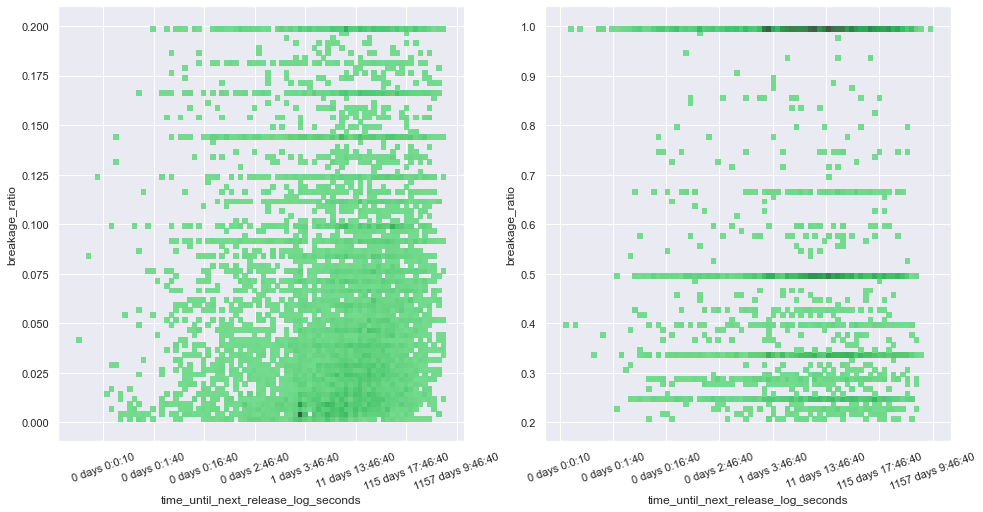

In [184]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

params = dict(
    data=filtered_for_hist[~filtered_for_hist['is_breaking_release']],
    x="time_until_next_release_log_seconds",
    y="breakage_ratio",
)

ax_1 = create_hist_plot(params, ax_1)
x_seconds = [10 ** x for x in ax_1.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax_1.set_xticklabels(xlabels, rotation=20)
# ax.set_yticklabels([int(10 ** y) for y in ax.get_yticks()], size=14)

params = dict(
    data=filtered_for_hist[filtered_for_hist['is_breaking_release']],
    x="time_until_next_release_log_seconds",
    y="breakage_ratio",
)

ax_2 = create_hist_plot(params, ax_2)
x_seconds = [10 ** x for x in ax_2.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax_2.set_xticklabels(xlabels, rotation=20)

plt.show()

<ipython-input-185-1546bbceee3d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=20)


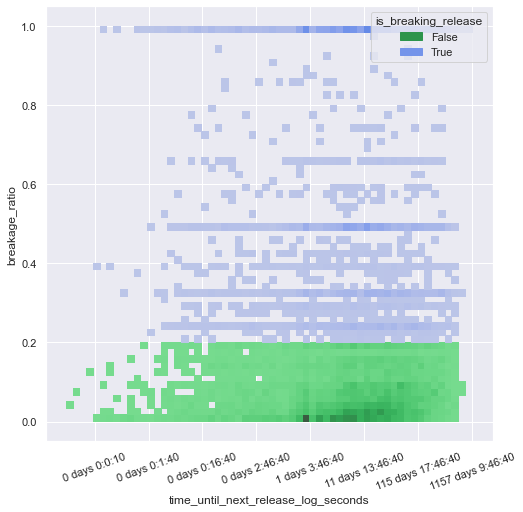

In [185]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))


params = dict(
    data=filtered_for_hist,
    x="time_until_next_release_log_seconds",
    y="breakage_ratio",
    hue="is_breaking_release",
    palette=TWO_COLOUR_PALETTE,
)

ax = create_hist_plot(params, ax, bins=60)
x_seconds = [10 ** x for x in ax.get_xticks()]
xlabels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(x_seconds, unit='s')]
ax.set_xticklabels(xlabels, rotation=20)
# ax.set_yticklabels([int(10 ** y) for y in ax.get_yticks()], size=14)

plt.show()

<ipython-input-186-e2e864da7c0f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_labels, rotation=0, fontsize=TICK_FONT_SIZE)


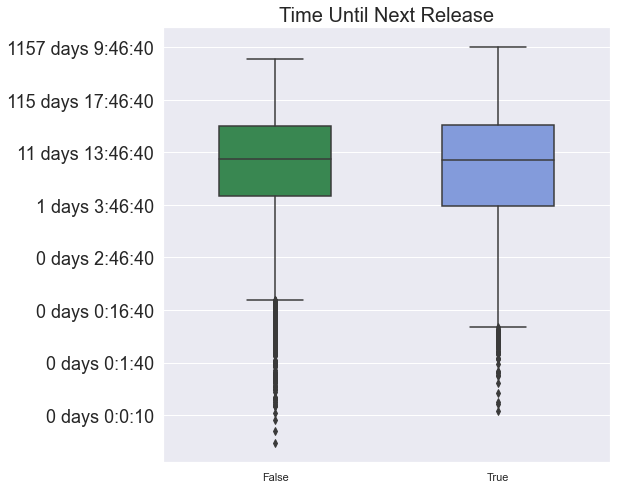

In [186]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

TICK_FONT_SIZE = 18
X_TICK_ROTATION = 30
X_TICK_TRANS = -40

params = dict(
    data=filtered_for_hist,
    y="time_until_next_release_log_seconds",
    x='is_breaking_release',
)
ax = sns.boxplot(
    **params,
    ax=ax,
#     order=['Avg. Across All Releases', 'After Breaking Release'],
    palette=TWO_COLOUR_PALETTE,
    width=0.5,
)
ax.set_title(f'Time Until Next Release', fontsize=20)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('', fontsize=20)
y_seconds = [10 ** x for x in ax.get_yticks()]
y_labels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(y_seconds, unit='s')]
ax.set_yticklabels(y_labels, rotation=0, fontsize=TICK_FONT_SIZE)
# x_labels = [x.get_text() for x in ax_1.get_xticklabels()]
# ax.set_xticklabels(x_labels, fontsize=TICK_FONT_SIZE)
plt.show()

<ipython-input-198-b9602e30a0ac>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_yticklabels(labels, rotation=0, fontsize=TICK_FONT_SIZE)
<ipython-input-198-b9602e30a0ac>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_yticklabels(y_labels, rotation=0, fontsize=TICK_FONT_SIZE)


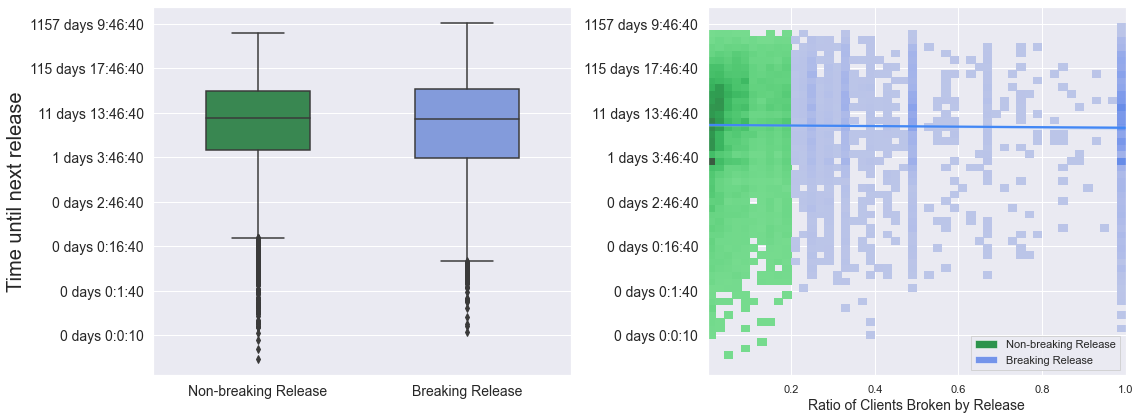

In [198]:
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))


TICK_FONT_SIZE = 14
X_TICK_ROTATION = 30
X_TICK_TRANS = -40

params_1 = dict(
    data=filtered_for_hist,
    y="time_until_next_release_log_seconds",
    x='is_breaking_release',
)
ax_1 = sns.boxplot(
    **params_1,
    ax=ax_1,
    palette=TWO_COLOUR_PALETTE,
    width=0.5,
)
ax.set_title(f'', fontsize=20)
ax_1.set_ylabel('Time until next release', fontsize=20)
ax_1.set_xlabel('', fontsize=20)
seconds = [10 ** x for x in ax_1.get_yticks()]
labels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(seconds, unit='s')]
ax_1.set_yticklabels(labels, rotation=0, fontsize=TICK_FONT_SIZE)
ax_1.set_xticklabels(["Non-breaking Release", 'Breaking Release'], fontsize=TICK_FONT_SIZE)


params_2 = dict(
    data=filtered_for_hist,
    y="time_until_next_release_log_seconds",
    x="breakage_ratio",
    hue="is_breaking_release",
    palette=TWO_COLOUR_PALETTE,
)

ax_2 = create_hist_plot(params_2, ax_2, bins=50)
ax_2 = sns.regplot(
    data=filtered_for_hist,
    y="time_until_next_release_log_seconds",
    x="breakage_ratio",
    scatter=False,
    line_kws={"color": BLUE},
    ax=ax_2,
)

ax.set_title(f'', fontsize=20)
ax_2.set_ylabel('', fontsize=20)
ax_2.set_xlabel('Ratio of Clients Broken by Release', fontsize=TICK_FONT_SIZE)
y_seconds = [10 ** x for x in ax_2.get_yticks()]
y_labels = [strfdelta(x, "{days} days {hours}:{minutes}:{seconds}") for x in pd.to_timedelta(y_seconds, unit='s')]
ax_2.set_yticklabels(y_labels, rotation=0, fontsize=TICK_FONT_SIZE)

leg_non_breaking = mpatches.Patch(facecolor=TWO_COLOUR_PALETTE[0], label='Non-breaking Release', linewidth = 0.5)
leg_breaking = mpatches.Patch(facecolor=TWO_COLOUR_PALETTE[1], label = 'Breaking Release', linewidth = 0.5)
ax_2.legend(
    handles=[leg_non_breaking, leg_breaking],
    title="",
    fancybox=False,
    loc=4
)

fig.tight_layout()
plt.show()
save_plot(fig, 'time_until_next_release_after_break_plots.png')

In [188]:
breaking_release_times = list(
    filtered_for_hist[filtered_for_hist['is_breaking_release']]['time_until_next_release_seconds']
)
non_breaking_release_times = list(
    filtered_for_hist[~filtered_for_hist['is_breaking_release']]['time_until_next_release_seconds']
)
from scipy import stats
mwr = stats.mannwhitneyu(breaking_release_times, non_breaking_release_times)

anova_oneway = stats.f_oneway(breaking_release_times, non_breaking_release_times)
anova_oneway
mwr
# len(non_breaking_release_times)

MannwhitneyuResult(statistic=20720855.5, pvalue=0.15924060662161316)